# MetroInsight Data Exploration and Analysis
This notebook contains various plots and models on UCSD sensor data, including building systems, energy meters, and collected travel times from Google Maps.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.ar_model
import sklearn.linear_model

%matplotlib inline
plt.rcParams['figure.max_open_warning'] = 0

data_dir = 'data/'

### Building Depot Data Plots

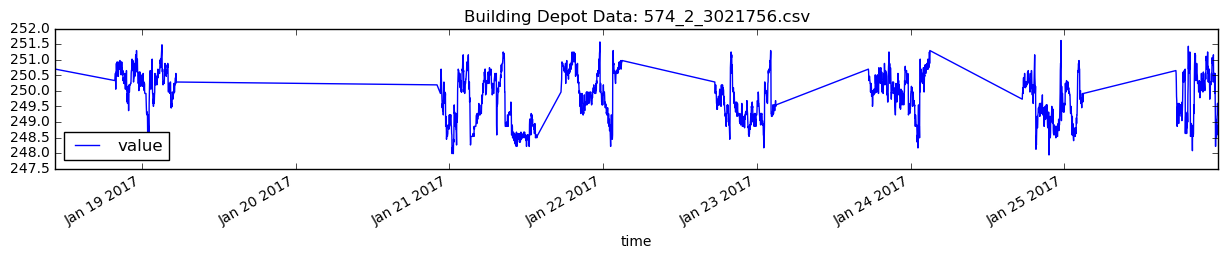

In [2]:
# Sensor: SME.ROOF.EF3-VFD1.OUTPUT - VOLT
df = pd.read_csv(data_dir + 'buildingdepot/data/574_2_3021756.csv')
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 2))
plt.title('Building Depot Data: 574_2_3021756.csv')

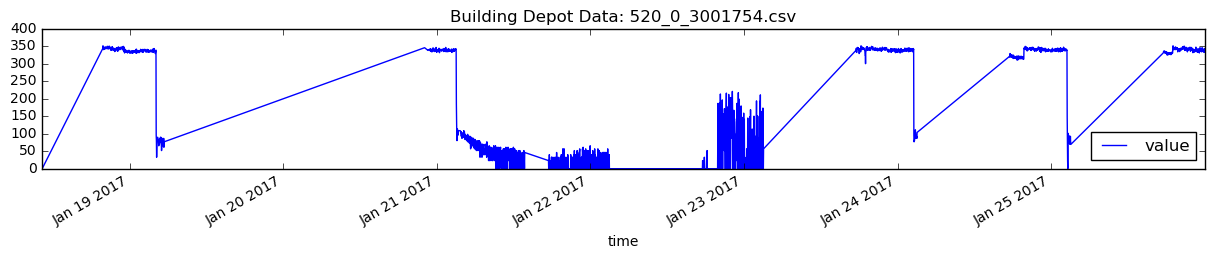

In [3]:
# Sensor: SDSC.1stFl.RM-162.VAV-14.SUP-FLOW
df = pd.read_csv(data_dir + 'buildingdepot/data/520_0_3001754.csv')
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 2))
plt.title('Building Depot Data: 520_0_3001754.csv')

### ION Data Plots

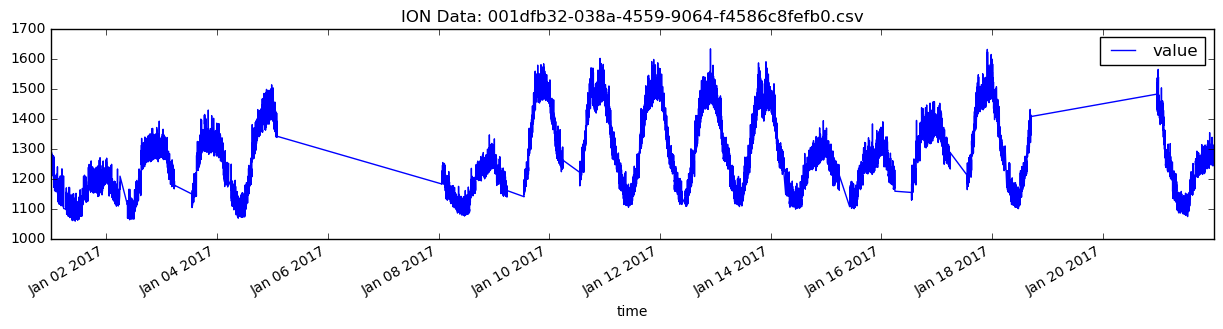

In [4]:
# Sensor: NCSS.Feeder_6B_E4624_RealTime:Real Power
df = pd.read_csv(data_dir + 'ion_data/data/001dfb32-038a-4559-9064-f4586c8fefb0.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('ION Data: 001dfb32-038a-4559-9064-f4586c8fefb0.csv')

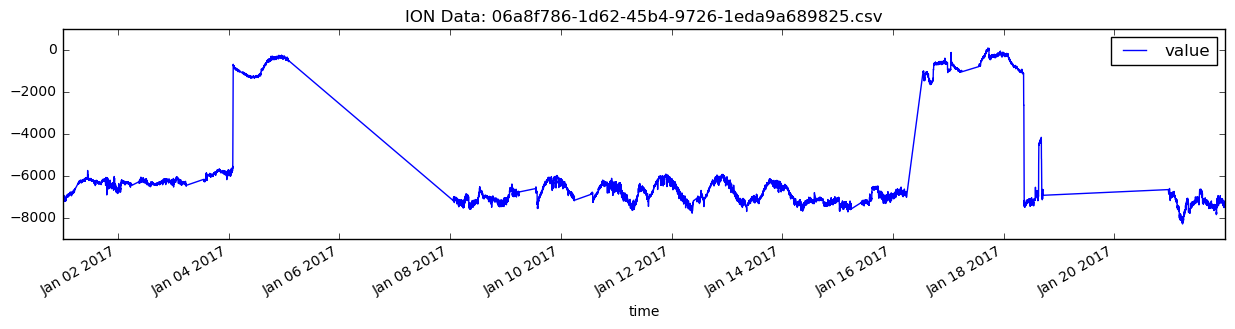

In [5]:
# Sensor: RE.MCB_100_E7280_RealTime:Real Power
df = pd.read_csv(data_dir + 'ion_data/data/06a8f786-1d62-45b4-9726-1eda9a689825.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('ION Data: 06a8f786-1d62-45b4-9726-1eda9a689825.csv')

### Google Traffic Data Plots

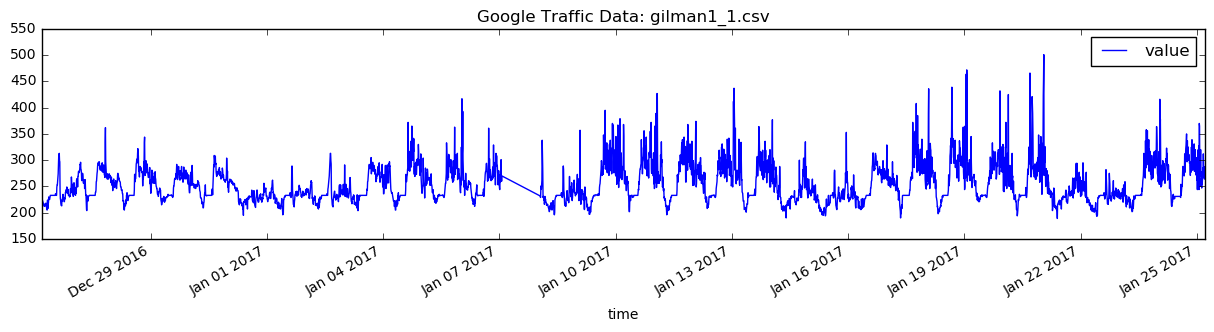

In [6]:
# Google Maps estimated travel time on Gilman Drive
# Start: (32.876222, -117.23014), End: (32.872524, -117.237882)
df = pd.read_csv(data_dir + 'google_traffic/data/gilman1_1.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('Google Traffic Data: gilman1_1.csv')

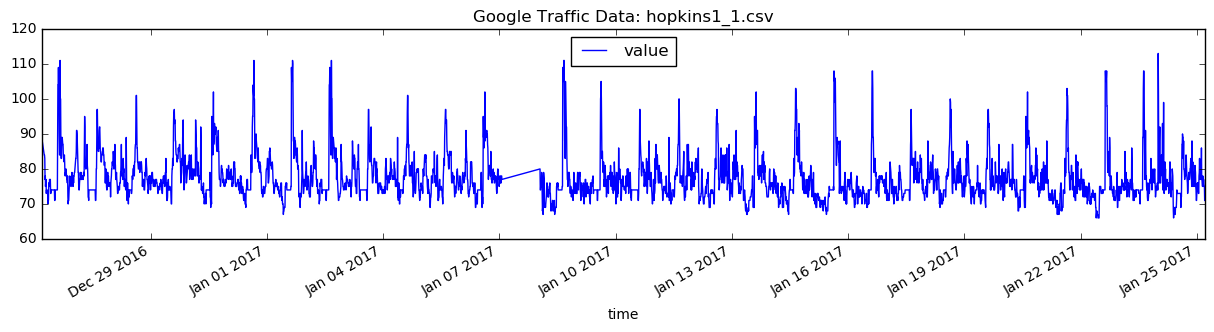

In [7]:
# Google Maps estimated travel time on Hopkins Drive
# Start: (32.883612, -117.238656), End: (32.88882, -117.240318)
df = pd.read_csv(data_dir + 'google_traffic/data/hopkins1_1.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('Google Traffic Data: hopkins1_1.csv')

### Autoregression Model
- Predict future travel times on Google Traffic data.

RMSE: 19.4329029292


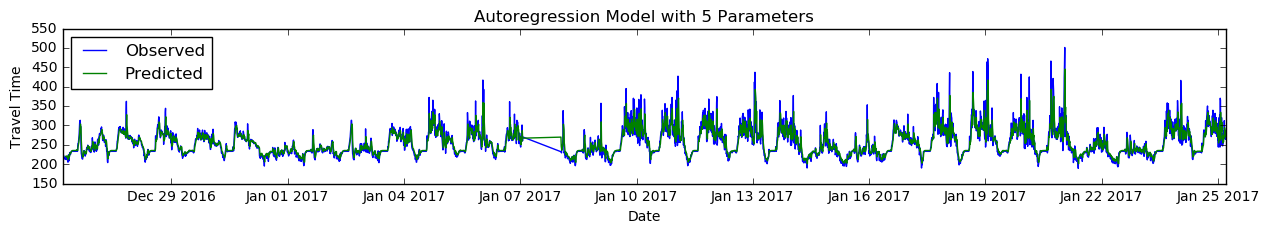

In [8]:
# Train an Autoregression model using the Statsmodels library
df = pd.read_csv(data_dir + 'google_traffic/data/gilman1_1.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

ar_mod = statsmodels.tsa.ar_model.AR(df['value']).fit(maxlag=5)
errors = df['value'] - ar_mod.fittedvalues
rmse = np.sqrt(errors.pow(2).mean())
print 'RMSE: ' + str(rmse)

plt.figure(figsize=(15, 2))
plt.plot(df['value'], label='Observed')
plt.plot(ar_mod.fittedvalues, label='Predicted')
plt.title('Autoregression Model with 5 Parameters')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')

### Autoregression Model with Weather Data
- Try introducing hourly weather features and compare performance.

In [9]:
# Read and process historical San Diego weather data
weather_files = sorted(glob.glob(data_dir + 'google_traffic/weather_data/*.csv'))
weather_frames = []
for filename in weather_files:
    hourly_df = pd.read_csv(filename)
    hourly_df['DateUTC'] = pd.to_datetime(hourly_df['DateUTC'])
    weather_frames.append(hourly_df)
    
weather_df = pd.concat(weather_frames, ignore_index=True)
weather_df = weather_df.set_index('DateUTC')
weather_df = weather_df.fillna({'PrecipitationIn': 0})
weather_df.loc[weather_df['Wind SpeedMPH'] == 'Calm', 'Wind SpeedMPH'] = 0
weather_df['Wind SpeedMPH'] = weather_df['Wind SpeedMPH'].astype(float)
weather_df = weather_df.drop(['TimePST', 'Dew PointF', 'Humidity', 'Sea Level PressureIn',
                              'VisibilityMPH', 'Wind Direction', 'Gust SpeedMPH', 'Events',
                              'Conditions', 'WindDirDegrees'], axis=1)

In [10]:
# Join Google Traffic and Weather Underground data
nearest_indices = np.searchsorted(weather_df.index, df.index)
df['WeatherIdx'] = weather_df.index.get_values()[nearest_indices]
merged = pd.merge(df, weather_df, left_on='WeatherIdx', right_index=True)
merged = merged.drop(['WeatherIdx'], axis=1)
df = df.drop(['WeatherIdx'], axis=1)

RMSE: 19.3735862453


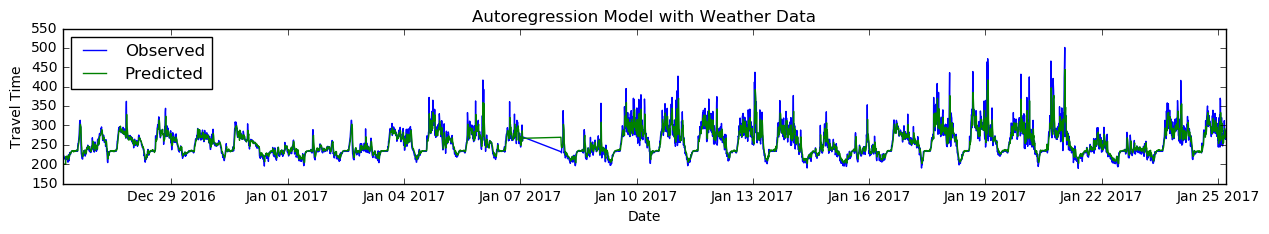

In [11]:
# Train Autoregression model using weather features
order = 5

X = []
y = []

for i in range(order, len(merged)):
    example = merged['value'].values[i-order:i]
    example = np.concatenate((example, merged['TemperatureF'].values[i-order:i]))
    example = np.concatenate((example, merged['Wind SpeedMPH'].values[i-order:i]))
    example = np.concatenate((example, merged['PrecipitationIn'].values[i-order:i]))
    example = np.insert(example, 0, 1, axis=0)  # Add bias term
    X.append(example)
    y.append(merged['value'].values[i])

X = np.vstack(X).astype(np.float32)
y = np.array(y).astype(np.float32)
y = np.reshape(y, (len(y), 1))

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)
rmse = np.sqrt(np.mean((model.predict(X) - y)**2))
print 'RMSE: ' + str(rmse)

merged['predictions'] = np.pad(model.predict(X), ((5, 0), (0, 0)), 'constant', constant_values=200)
plt.figure(figsize=(15, 2))
plt.plot(merged['value'], label='Observed')
plt.plot(merged['predictions'], label='Predicted')
plt.title('Autoregression Model with Weather Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')

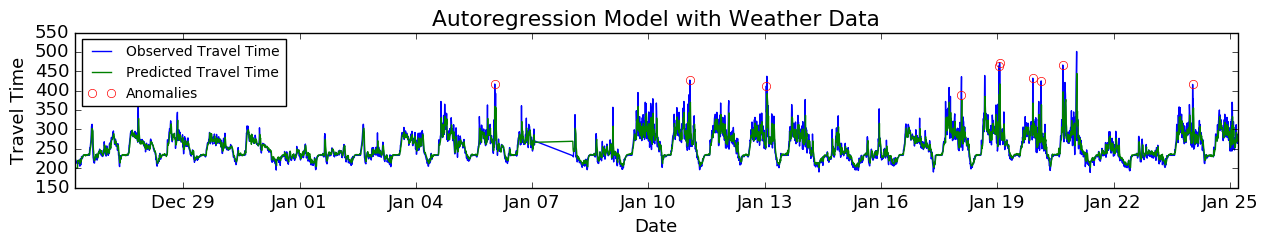

In [12]:
# Plot the model predictions along with the largest observed anomalies
merged['errors'] = merged['value'] - merged['predictions']
errors = merged['errors'].sort_values()

anomalies_X = []
anomalies_y = []

for i in range(-10, 0):
    anomalies_X.append(errors.index[i])
    anomalies_y.append(merged['value'][errors.index[i]])

matplotlib.rcParams.update({'font.size': 13})
plt.rc('legend', fontsize=10)
fig = plt.figure(figsize=(15, 2))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.plot(merged['value'], label='Observed Travel Time')
plt.plot(merged['predictions'], label='Predicted Travel Time')
plt.plot(anomalies_X, anomalies_y, 'o', label='Anomalies',
         markeredgecolor='red', markerfacecolor='none')
plt.title('Autoregression Model with Weather Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')
plt.show()

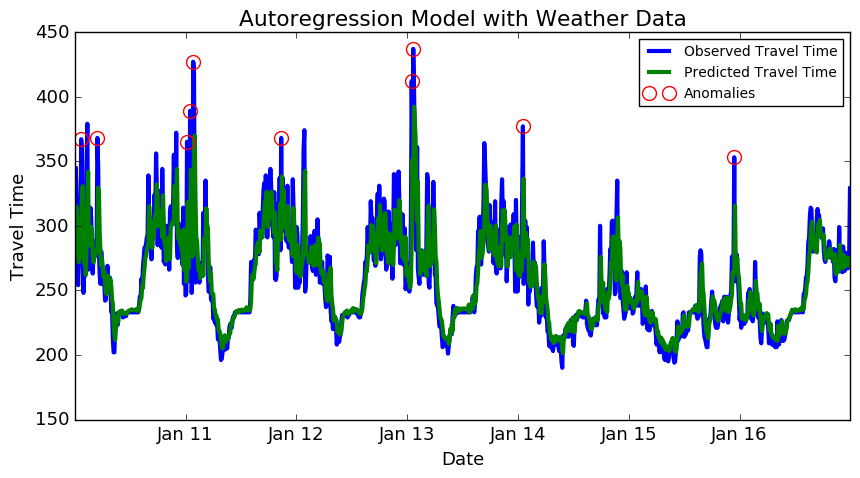

In [13]:
# Show a one-week subset of the above plot
merged_week = merged[(merged.index >= '2017-01-10') & (merged.index < '2017-01-17')]
errors = merged_week['errors'].sort_values()

anomalies_X = []
anomalies_y = []
for i in range(-10, 0):
    anomalies_X.append(errors.index[i])
    anomalies_y.append(merged_week['value'][errors.index[i]])

matplotlib.rcParams.update({'font.size': 13})
plt.rc('legend', fontsize=10)
fig = plt.figure(figsize=(10, 5))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.plot(merged_week['value'], label='Observed Travel Time', linewidth=3)
plt.plot(merged_week['predictions'], label='Predicted Travel Time', linewidth=3)
plt.plot(anomalies_X, anomalies_y, 'o', label='Anomalies',
        markeredgecolor='red', markerfacecolor='none', markersize=10,
        markeredgewidth=1)
plt.legend(loc='best')
plt.title('Autoregression Model with Weather Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.show()

### Autoregression Model: Including ION Datasets
- Try to predict Google Traffic travel time based on previous travel time values, weather data, and ION sensor values.
- Use Lasso regression to extract only those features which are the most predictive of travel times.

In [14]:
# Read and process ION data files
ion_files = sorted(glob.glob(data_dir + 'ion_data/data/*.csv'))
ion_frames = []
for i in range(len(ion_files)):
    ion_df = pd.read_csv(ion_files[i], header=None, names=['time', 'value_' + str(i)])
    ion_df['time'] = pd.to_datetime(ion_df['time'])
    ion_df = ion_df.set_index('time')
    ion_frames.append(ion_df)
    
for ion_df in ion_frames:
    indices = np.searchsorted(ion_df.index, df.index)
    indices[indices == len(ion_df)] = len(ion_df) - 1
    df['ion_indices'] = ion_df.index.get_values()[indices]
    df = pd.merge(df, ion_df, left_on='ion_indices', right_index=True)

In [15]:
# Add previously observed travel times (autoregression terms)
# and weather data
nearest_indices = np.searchsorted(weather_df.index, df.index)
df['WeatherIdx'] = weather_df.index.get_values()[nearest_indices]
merged = pd.merge(df, weather_df, left_on='WeatherIdx', right_index=True)
merged = merged.drop(['WeatherIdx'], axis=1)
df = df.drop(['WeatherIdx'], axis=1)

for i in range(1, 6):
    merged['prev_' + str(i)] = merged.value.shift(i)

merged = merged.iloc[5:]

RMSE: 17.1671389921
Number of nonzero features: 748


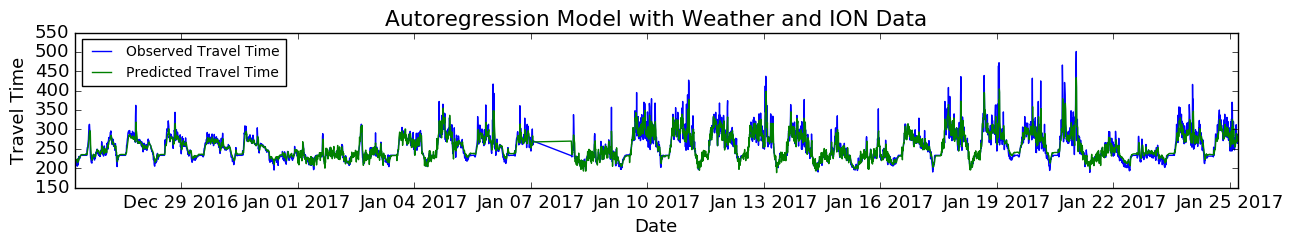

In [17]:
# Train a Lasso Regression model and display the results
cols = ['value_' + str(i) for i in range(len(ion_frames))]
cols += ['TemperatureF', 'Wind SpeedMPH', 'PrecipitationIn']
cols += ['prev_' + str(i) for i in range(1, 6)]
X = merged[cols].values
y = merged['value'].values

clf = sklearn.linear_model.Lasso(alpha=0.01)
clf.fit(X, y)
rmse = np.sqrt(np.mean((clf.predict(X) - y)**2))
print 'RMSE: ' + str(rmse)

num_nonzero = sum([1 for i in clf.coef_ if i != 0.0])
print 'Number of nonzero features: ' + str(num_nonzero)

merged['predictions'] = clf.predict(X)
plt.figure(figsize=(15, 2))
plt.plot(merged['value'], label='Observed Travel Time')
plt.plot(merged['predictions'], label='Predicted Travel Time')
plt.title('Autoregression Model with Weather and ION Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')

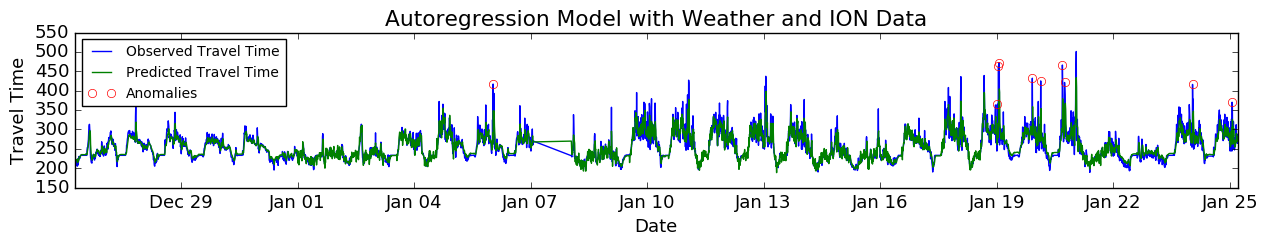

In [18]:
# Plot the model predictions along with the largest observed anomalies
merged['errors'] = merged['value'] - merged['predictions']
errors = merged['errors'].sort_values()

anomalies_X = []
anomalies_y = []

for i in range(-10, 0):
    anomalies_X.append(errors.index[i])
    anomalies_y.append(merged['value'][errors.index[i]])

matplotlib.rcParams.update({'font.size': 13})
plt.rc('legend', fontsize=10)
fig = plt.figure(figsize=(15, 2))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.plot(merged['value'], label='Observed Travel Time')
plt.plot(merged['predictions'], label='Predicted Travel Time')
plt.plot(anomalies_X, anomalies_y, 'o', label='Anomalies',
         markeredgecolor='red', markerfacecolor='none')
plt.title('Autoregression Model with Weather and ION Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')
plt.show()

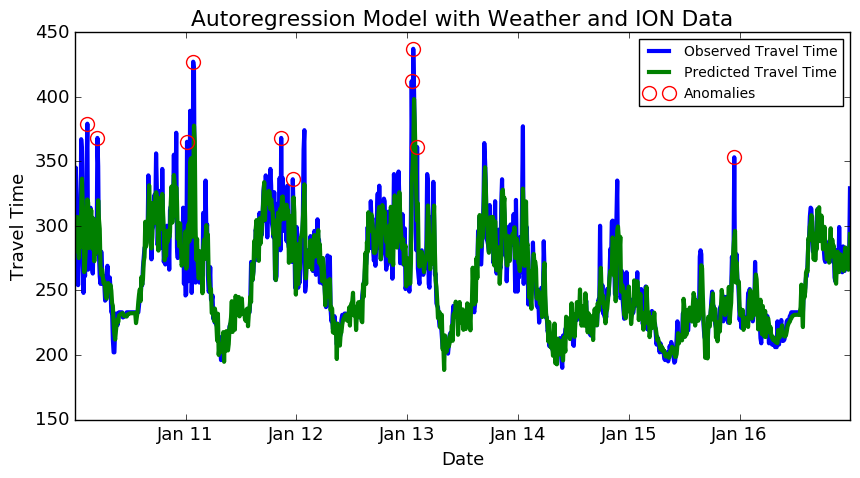

In [19]:
# Show a one-week subset of the above plot
merged_week = merged[(merged.index >= '2017-01-10') & (merged.index < '2017-01-17')]
errors = merged_week['errors'].sort_values()

anomalies_X = []
anomalies_y = []
for i in range(-10, 0):
    anomalies_X.append(errors.index[i])
    anomalies_y.append(merged_week['value'][errors.index[i]])

matplotlib.rcParams.update({'font.size': 13})
plt.rc('legend', fontsize=10)
fig = plt.figure(figsize=(10, 5))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.plot(merged_week['value'], label='Observed Travel Time', linewidth=3)
plt.plot(merged_week['predictions'], label='Predicted Travel Time', linewidth=3)
plt.plot(anomalies_X, anomalies_y, 'o', label='Anomalies',
        markeredgecolor='red', markerfacecolor='none', markersize=10,
        markeredgewidth=1)
plt.legend(loc='best')
plt.title('Autoregression Model with Weather and ION Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.show()

data/ion_data/data/0017c56c-7dc2-4c31-9e91-0c90b6fabc54.csv
data/ion_data/data/001dfb32-038a-4559-9064-f4586c8fefb0.csv
data/ion_data/data/001e9588-04ad-414b-bea3-caa583d4ef3f.csv
data/ion_data/data/002f6932-9179-4ec8-b58c-5ef31d0f97ea.csv
data/ion_data/data/0039aaab-e07b-4fce-beff-11a0316a2937.csv
data/ion_data/data/006f33dd-beae-49d5-961b-a2b8520cb347.csv
data/ion_data/data/00754ed1-1513-4736-84cf-c7249279797a.csv
data/ion_data/data/00ca54b9-1eb9-45e8-b93d-ddf4f38c91c7.csv
data/ion_data/data/011c609c-4e30-49f7-8779-dc966275c59b.csv
data/ion_data/data/013a9dd8-ab13-4ffc-9265-a3deb9dc0177.csv


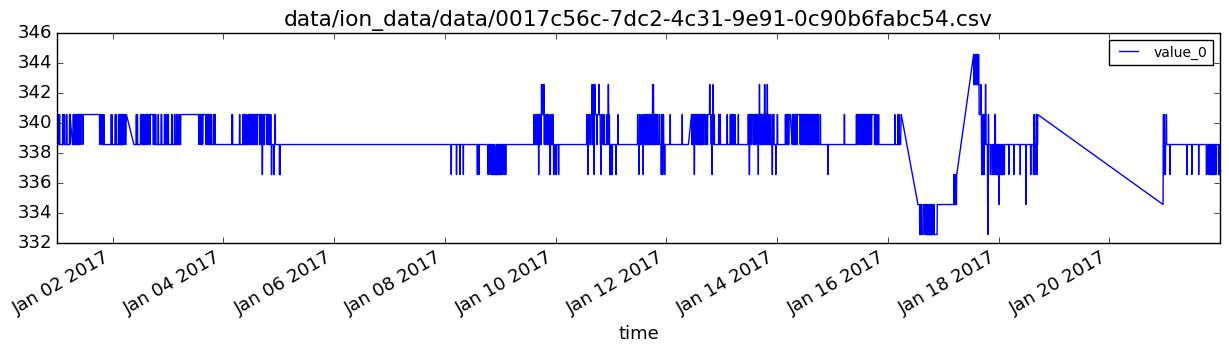

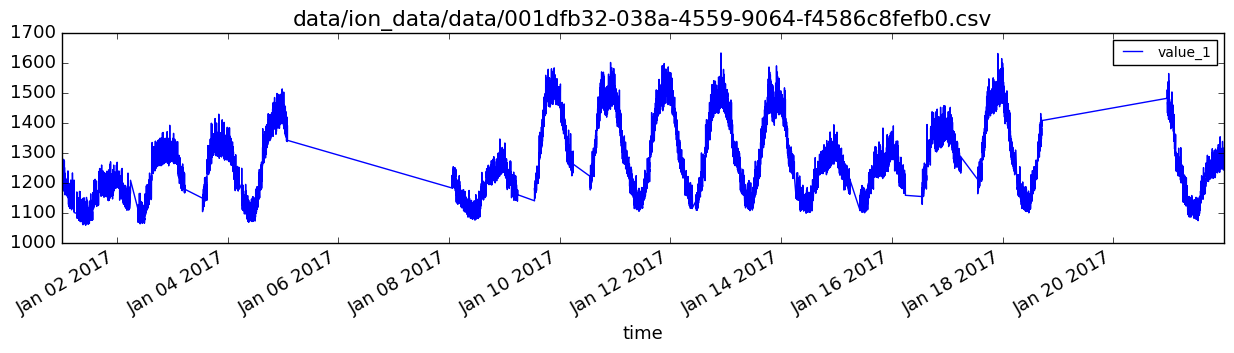

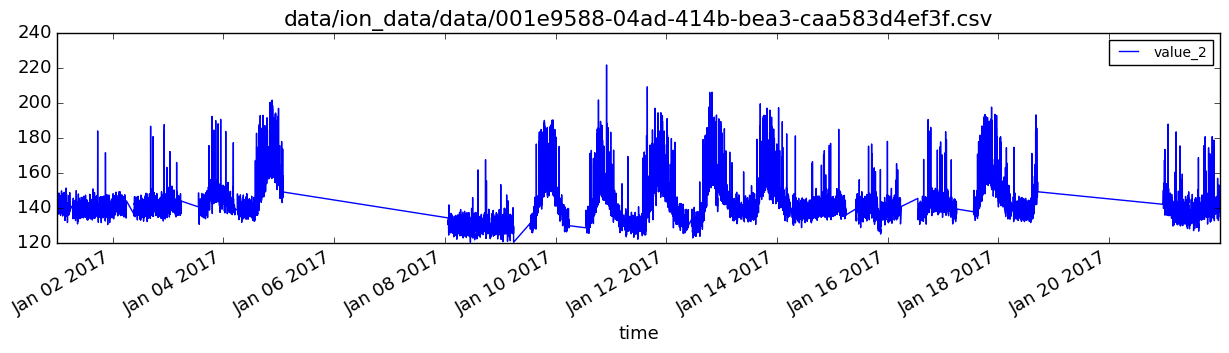

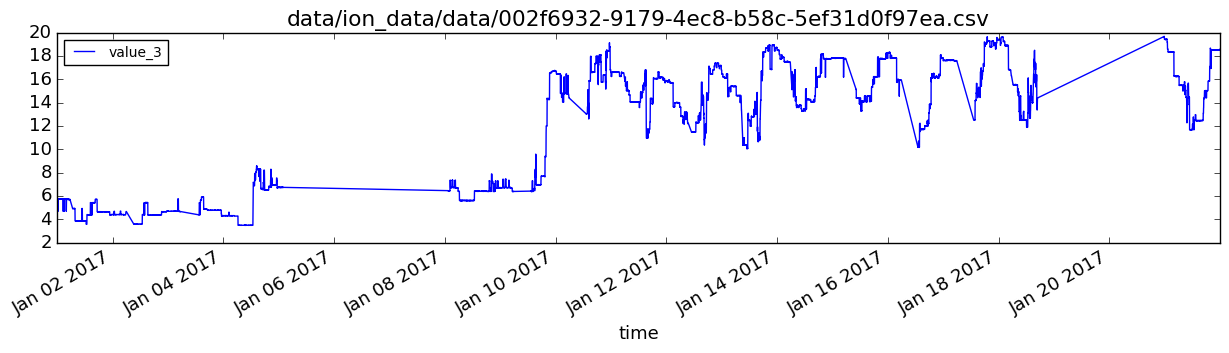

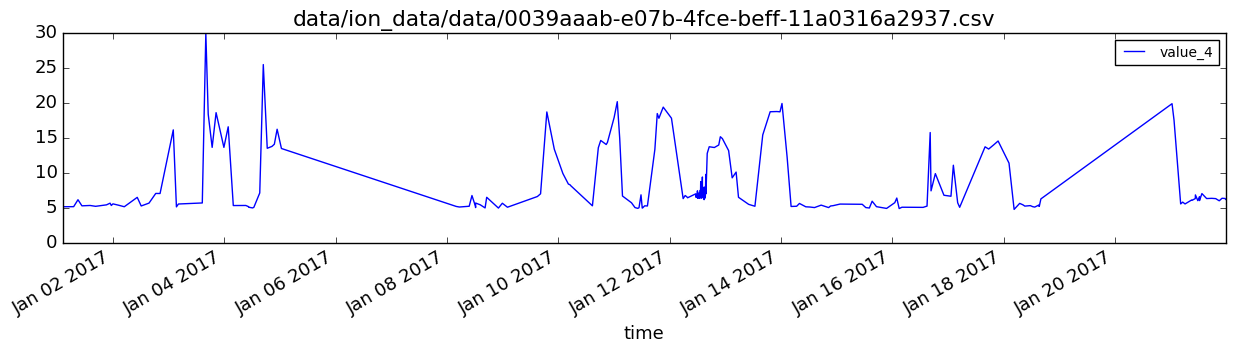

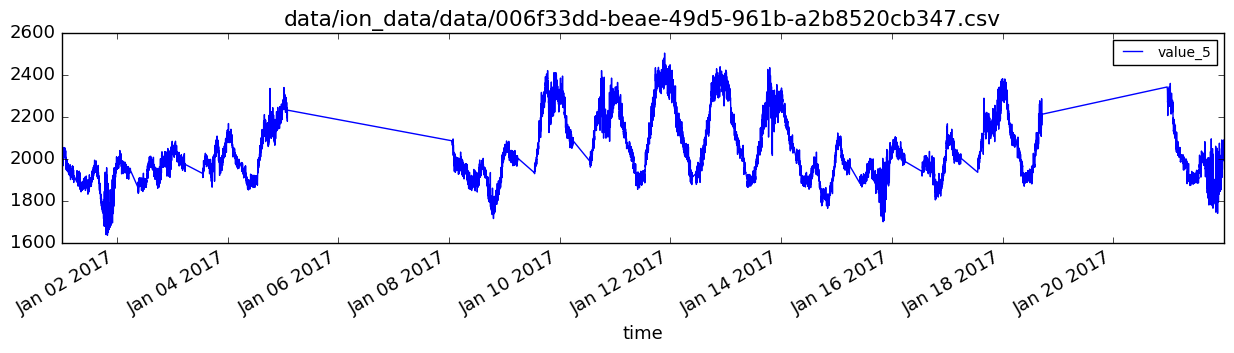

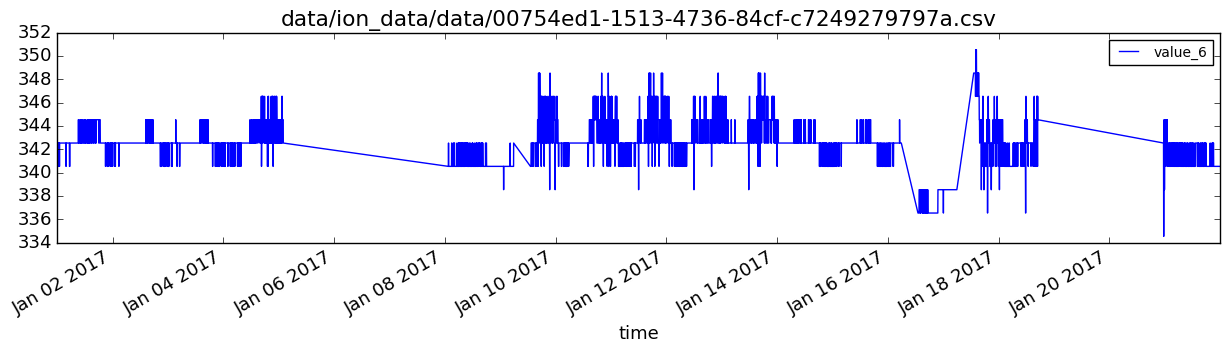

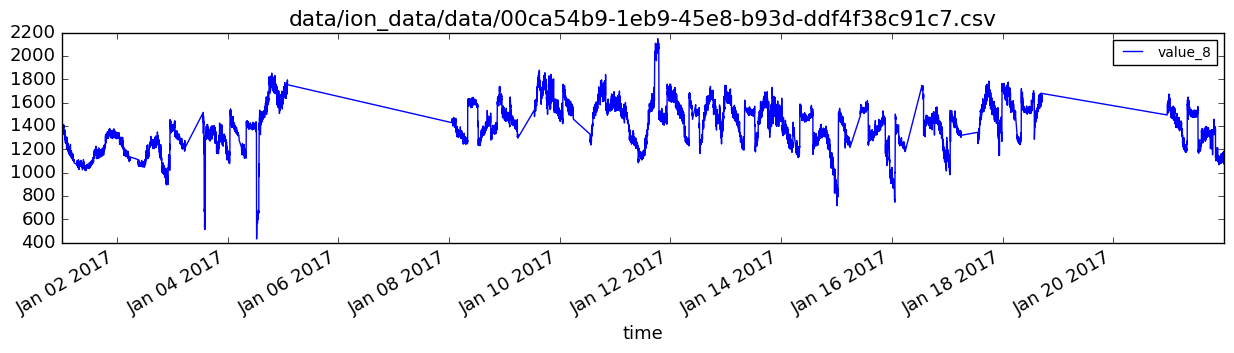

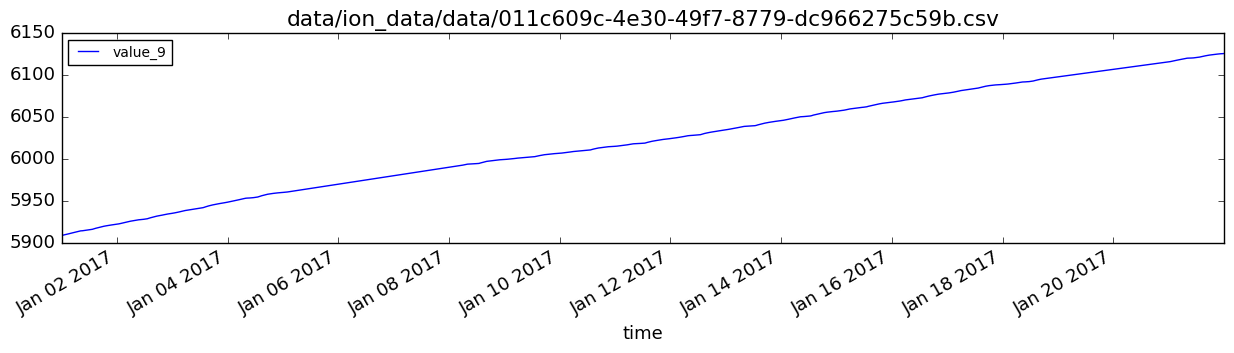

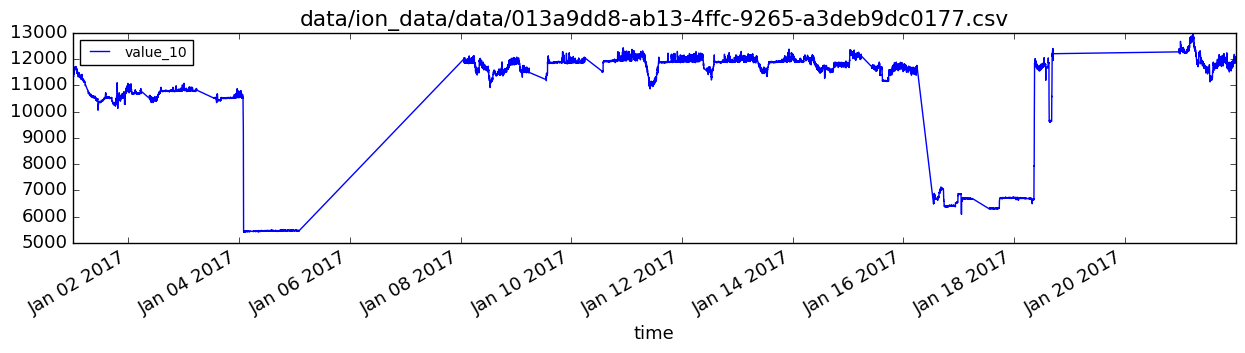

In [20]:
# Plot some ION sensors with nonzero model coefficients
for idx in np.nonzero(clf.coef_)[0][:10]:
    print ion_files[idx]
    ion_df = pd.read_csv(ion_files[idx], header=None, names=['time', 'value_' + str(idx)])
    ion_df['time'] = pd.to_datetime(ion_df['time'])
    ion_df.plot(x='time', y='value_' + str(idx), figsize=(15, 3))
    plt.title(ion_files[idx])